In [30]:
% matplotlib inline
from utils.utils import nameRules as nr
from utils.utils import *
import utils.geometryOp as go
from utils.preprocessing import *

import csv
import os
from os.path import exists, join

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import SimpleITK as sitk
import cv2

import numpy as np
import math
from scipy import ndimage

import copy

In [31]:
"""
parameters
"""
img_root_dir = 'Spine_Example_Radiographs'
csv_file = 'test1.csv'
ImgPointer = 5 # which image to be studied in this notebook, 5 is an example that posterior is on the left
square = True # if we want to force the bounding box to be square
resized_img_size = (264, 264) # finally resized image size
expands = [100,100] # expand each box 

In [32]:
"""
Construct imgIDList;
get store dict;
construct the number of labelled vbs of each image
"""
ImgIDList = get_ImgIDList(img_root_dir)
StoreDict = label_dict_constructor(csv_file, ImgIDList)
LabelledVBNumDict = VB_num_dict_constructor(StoreDict)
VBLabelList = nr.VBLabelList

In [33]:
"""
The functons about drawing
"""

"""
Display the current image
    input:
    ImgPointer: the position of the image in the list
"""
def display_img(ImgPointer, fig, axes, xy_range=[], which_vb = None):
    # Get the grey value of the image as a numpy array
    img = sitk.ReadImage(ImgIDList[ImgPointer])[:,:,0]
    npa = np.array(sitk.GetArrayViewFromImage(img))
    
    if len(xy_range) != 0:
        x_max = xy_range[0]
        x_min = xy_range[1]
        y_max = xy_range[2]
        y_min = xy_range[3]
        npa = npa[y_min:y_max, x_min:x_max]
    else:
        x_max = len(npa[0])
        x_min = 0
        y_max = len(npa)
        y_min = 0
    
    min_intensity = npa.min()
    max_intensity = npa.max()
#     print(npa.shape)

    ## show the image
    axes.imshow(npa,
                cmap=plt.cm.Greys_r,
                vmin=min_intensity,
                vmax=max_intensity)
    axes.set_xlim(0,len(npa[0]))
    axes.set_ylim(len(npa),0)

    plt.tight_layout()
    
    # display the points
    text_x_offset = 6
    text_y_offset = -8
    text_font = 6
    cur_imgID = ImgIDList[ImgPointer]
    marker_size = 40

    # center coords
    co = len(VBLabelList) # count of the center points
    for i, vb in enumerate(VBLabelList):
        if which_vb != None and i != which_vb:
            continue
        if StoreDict[cur_imgID][vb][nr.Fracture] == nr.normal:
            color = 'yellow'
        elif StoreDict[cur_imgID][vb][nr.Fracture] == nr.ost:
            color = 'orange'
        elif StoreDict[cur_imgID][vb][nr.Fracture] == nr.non_ost:
            color = 'green'
        pnt = StoreDict[cur_imgID][vb][nr.Coords]
        if pnt[0] == None or pnt[1] == None:
            co -= 1
            continue
        pnt = (pnt[0]-x_min, pnt[1]-y_min)
        axes.scatter(pnt[0], pnt[1], s=marker_size, marker='+', color=color)
        # Get point in pixels.
        text_in_data_coords = axes.transData.transform([pnt[0],pnt[1]])
        # Offset in pixels and get in data coordinates.
        text_in_data_coords = axes.transData.inverted().\
            transform((text_in_data_coords[0]+text_x_offset, text_in_data_coords[1]+text_y_offset))
        axes.text(text_in_data_coords[0], text_in_data_coords[1], vb, color=color, fontsize=text_font)
    # corner coords
    cor_co = len(VBLabelList) # count of the corner points
    for i, vb in enumerate(VBLabelList):
        if which_vb != None and i != which_vb:
            continue
        if StoreDict[cur_imgID][vb][nr.Fracture] == nr.normal:
            color = 'yellow'
        elif StoreDict[cur_imgID][vb][nr.Fracture] == nr.ost:
            color = 'orange'
        elif StoreDict[cur_imgID][vb][nr.Fracture] == nr.non_ost:
            color = 'green'
        pnt = StoreDict[cur_imgID][vb][nr.CorCoords]
        if pnt[0] == None or pnt[1] == None:
            cor_co -= 1
            continue
        pnt = (pnt[0]-x_min, pnt[1]-y_min)
        axes.scatter(pnt[0], pnt[1], s=marker_size, marker='*', color=color)
        # Get point in pixels.
        text_in_data_coords = axes.transData.transform([pnt[0],pnt[1]])
        # Offset in pixels and get in data coordinates.
        text_in_data_coords = axes.transData.inverted().\
            transform((text_in_data_coords[0]+text_x_offset, text_in_data_coords[1]+text_y_offset))
        axes.text(text_in_data_coords[0], text_in_data_coords[1], vb, color=color, fontsize=text_font)
    if len(xy_range) == 0:
        axes.set_title('localized {0} center points, {1} corner points'.format(co, cor_co))
    fig.canvas.draw_idle()
    
    return npa

"""
calculate the angle bisector of s1-l5-l4 and display, just a test
    input:
    ImgPointer: which image
    VBPointer: we what to find bisection along VBList[VBPointer-1] -- VBList[VBPointer] -- VBList[VBPointer+1]
    axes: which subplot we want to draw
"""
def draw_bisector_lines(ImgPointer, VBPointer, axes):
    cur_imgID = ImgIDList[ImgPointer]
    vb1 = VBLabelList[VBPointer-1]
    vb2 = VBLabelList[VBPointer]
    vb3 = VBLabelList[VBPointer+1]
    p1 = StoreDict[cur_imgID][vb1][nr.Coords]
    p2 = StoreDict[cur_imgID][vb2][nr.Coords]
    p3 = StoreDict[cur_imgID][vb3][nr.Coords]

    # center points and bisector norm
    cp, bn = go.get_angle_bisector(p1,p2,p3)
#     print(cp,bn)

    # draw them on figure 1
    line_12_x = np.linspace(p1[0], p2[0],100)
    line_12_y = np.linspace(p1[1], p2[1],100)
    axes.plot(line_12_x, line_12_y, color='yellow')

    line_23_x = np.linspace(p3[0], p2[0],100)
    line_23_y = np.linspace(p3[1], p2[1],100)
    axes.plot(line_23_x, line_23_y, color='yellow')

    bn_normal = go.vector_normalization(bn)
#     print(bn_normal)
    bisec_x = cp[0] + np.arange(0,1000,10)*bn_normal[0]
    bisec_y = cp[1] + np.arange(0,1000,10)*bn_normal[1]
    axes.plot(bisec_x, bisec_y, color='yellow')

"""
draw perpendicular line of line connecting the top/bottom two vb centers, intersecting on the top/bottom vb center
because for the top/bottom one vb, no way to get it's bisector, so we use normal
position has two modes, top and bottom
"""
def draw_perpendicular_line(ImgPointer, VBPointer, axes, position='top'):
    cur_imgID = ImgIDList[ImgPointer]
    vb1 = VBLabelList[VBPointer]
    if position == 'top':
        vb2 = VBLabelList[VBPointer-1]
    elif position == 'bottom':
        vb2 = VBLabelList[VBPointer+1]
    
    p1 = StoreDict[cur_imgID][vb1][nr.Coords]
    p2 = StoreDict[cur_imgID][vb2][nr.Coords]
    tangent = (p1[0]-p2[0], p1[1]-p2[1])
    normal = go.get_normal_vector(tangent)
    
    normal_x = p1[0] + np.arange(0,1000,10)*normal[0]
    normal_y = p1[1] + np.arange(0,1000,10)*normal[1]
    axes.plot(normal_x, normal_y, color='yellow')

"""
draw line segmentation given two points
"""
def draw_line_seg(p1, p2, axes, color='yellow'):
    line_12_x = np.linspace(p1[0], p2[0],100)
    line_12_y = np.linspace(p1[1], p2[1],100)
    axes.plot(line_12_x, line_12_y, color=color)

"""
draw bounding box of a vertebral, ginve the box corner wrt absolute coords
ab_box is a list contains 4 tuples of the corner coords
"""
def draw_bounding_box(ab_box, axes, color='yellow'):
    draw_line_seg(ab_box[0], ab_box[1], axes,color=color)
    draw_line_seg(ab_box[1], ab_box[2], axes, color=color)
    draw_line_seg(ab_box[2], ab_box[3], axes, color=color)
    draw_line_seg(ab_box[3], ab_box[0], axes, color=color)

In [34]:
"""
data augmentation
# scale
# translate
# grey
"""

'''
translate
input:
    bias: the original expands
    direction: the direction of translation
    distance: the distance of translation
output:
    the rst expands
'''
def _translate(bias, direction, distance):
    dir_x, dir_y = go.polar2cart(distance, direction)
    dir_in_cart = (dir_x, dir_y)
    
    rst_bias = []   
    rst_bias.append(bias[0]+dir_y)
    rst_bias.append(bias[1]+dir_x)
    if len(bias) == 2:
        rst_bias.append(bias[0]-dir_y)
        rst_bias.append(bias[1]-dir_x)
    elif len(bias) == 4:
        rst_bias.append(bias[2]-dir_y)
        rst_bias.append(bias[3]-dir_x)
    
    return rst_bias
'''
scale
input:
    bias: the original expands
    sup_pos_point: the superior/posterior corner point
    scale: the scale
output:
    the rst expands
'''
def _scale(bias, sup_pos_point, scale):
    rst_bias = []
    x = sup_pos_point[0]
    y = sup_pos_point[1]
    rst_bias.append(y/scale - (y - bias[0]))
    rst_bias.append(x/scale - (x - bias[1]))
    if len(bias) == 4:
        rst_bias.append(y/scale - (y - bias[2]))
        rst_bias.append(x/scale - (x - bias[3]))
    
    return rst_bias

'''
rotate
input:
    ab_box: the vb bounding box represented in absolute coordinates
    cen: the center point coordinates of a vb
    degree: the degree(not radian) of the vb rotation: 
        if positive, vb rotates anticlockwisely (i.e., the box rotates clockwisely); negative, clockwisely.
output: 
    the rotated vb bounding box
'''
def _rotate(ab_box, cen, degree):
    rst_cor = []
    for cor in ab_box:
        v = go.get_vector(cen, cor)
        r, theta = go.cart2polar(v[0], v[1])
        theta += math.radians(degree)

        rel_cor = go.polar2cart(r, theta)
        rst_cor.append(go.vector_add(cen, rel_cor))
        
    return rst_cor
    
    
    
    
# is_right: if back is towards right
def get_all_pieces(num_labelled_VBs, StoredInfo, img_path, expands=[100,100], square=False, 
                    data_augmentation=0, **kwargs):
    pieceBoxDict = {}
    pieceDict = {}
    pieceRangeDict = {}
    BoxDict = {}
    for i in range(num_labelled_VBs):
        # get bounding box
        vb2 = nr.VBLabelList[i]
        p2 = StoredInfo[vb2][nr.Coords]
        if i == 0:        
            vb3 = nr.VBLabelList[i+1]        
            p3 = StoredInfo[vb3][nr.Coords]
            vx = go.get_normal_vector(go.get_vector(p2,p3))
            cen = p2
        elif i == num_labelled_VBs - 1:
            vb3 = nr.VBLabelList[i-1]
            p3 = StoredInfo[vb3][nr.Coords]
            vx = go.get_normal_vector(go.get_vector(p2,p3))
            cen = p2
        else:  
            vb1 = nr.VBLabelList[i-1]
            vb3 = nr.VBLabelList[i+1]
            p1 = StoredInfo[vb1][nr.Coords]
            p3 = StoredInfo[vb3][nr.Coords]
            cen, vx = go.get_angle_bisector(p1,p2,p3)

        cor = StoredInfo[vb2][nr.CorCoords]
        
        ###################################################
        # data augmentation: scale and translation
        ###################################################        
        ab_box, rel_box = go.get_box_corners(cen, cor, vx, expands, square = square)
        is_right = img_orientation(ab_box)
        if data_augmentation == 1:
            direction = kwargs.get('translation_direction', math.pi/5)
            distance = kwargs.get('translation_distance', 100)
            bias = _translate(expands, direction, distance)
            ab_box, rel_box = go.get_box_corners(cen, cor, vx, bias, square = square)
        elif data_augmentation == 2:
#             ab_box, rel_box = go.get_box_corners(cen, cor, vx, expands, square = square)
            scale = kwargs.get('scaling_scale', 0.8)
            bias = _scale(expands, rel_box[0], scale)
            ab_box, rel_box = go.get_box_corners(cen, cor, vx, bias, square = square)
        elif data_augmentation == 3:
#             ab_box, rel_box = go.get_box_corners(cen, cor, vx, expands, square = square)
            ab_box = _rotate(ab_box, cen, -80)
        ###################################################
        
        
        # the large box
        xy_range = go.get_straight_box(ab_box)
          
        BoxDict[nr.VBLabelList[i]] = ab_box
        pieceRangeDict[nr.VBLabelList[i]] = xy_range

        img = sitk.ReadImage(img_path)[:,:,0]
        npa = np.array(sitk.GetArrayViewFromImage(img))
        piece = get_one_piece(npa, xy_range)
        pieceDict[nr.VBLabelList[i]] = piece
                
        # new ab_box for each piece
        x_max = xy_range[0]
        x_min = xy_range[1]
        y_max = xy_range[2]
        y_min = xy_range[3]
        piece_ab_box = []
        for j in range(4):
            piece_ab_box.append((ab_box[j][0]-x_min, ab_box[j][1]-y_min))
        pieceBoxDict[nr.VBLabelList[i]] = piece_ab_box
        
    return pieceDict, pieceBoxDict, BoxDict, pieceRangeDict, is_right





# of labelled VBs: 7


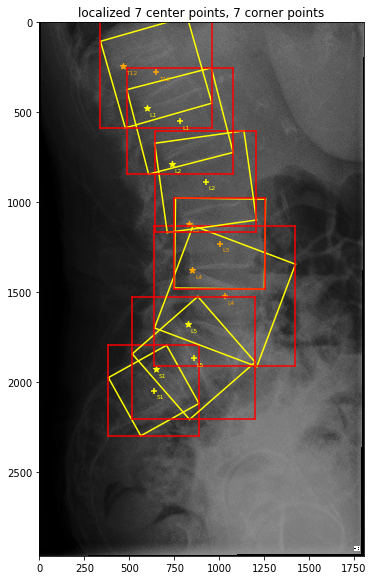

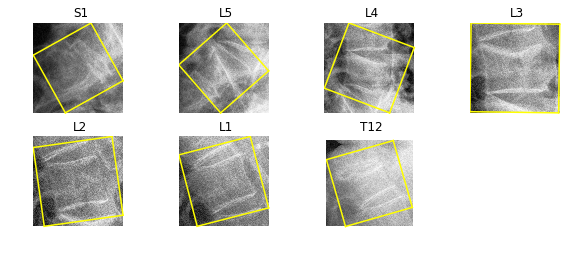

In [35]:
"""
Get pieces and bounding box
"""
# 1 for traslation, 2 for scale, 3 for rotation
data_augmentation = 3
num_labelled_VBs = LabelledVBNumDict[ImgIDList[ImgPointer]]
cur_imgID = ImgIDList[ImgPointer]
StoredInfo = StoreDict[cur_imgID]
img_path = ImgIDList[ImgPointer]
pieceDict, pieceBoxDict, BoxDict, pieceRangeDict, is_right = get_all_pieces(num_labelled_VBs, StoredInfo, 
                                                                  img_path, expands=expands, square=square,
                                                                  data_augmentation=3)


###########################################################
# below is plot related
###########################################################
fig = plt.figure(figsize=(10,8))
axes = plt.subplot(1,1,1)
display_img(ImgPointer, fig, axes)
print('# of labelled VBs: {0}'.format(LabelledVBNumDict[ImgIDList[ImgPointer]]))

fig2 = plt.figure(figsize=(10,8))
axes2 = []

for i in range(LabelledVBNumDict[ImgIDList[ImgPointer]]):
    # draw bounding box
    draw_bounding_box(BoxDict[VBLabelList[i]], axes)  
    # draw the straight box
    xy_range = pieceRangeDict[nr.VBLabelList[i]]
    x_max = xy_range[0]
    x_min = xy_range[1]
    y_max = xy_range[2]
    y_min = xy_range[3]
    
    large_box = []
    large_box.append((x_max, y_min))
    large_box.append((x_max, y_max))
    large_box.append((x_min, y_max))
    large_box.append((x_min, y_min))
    draw_bounding_box(large_box, axes, color='red')
    
    # cut the piece out
    axes2.append(plt.subplot(4,4,i+1))
    axes2[i].set_axis_off()
    axes2[i].set_title(VBLabelList[i])
#     img = sitk.ReadImage(ImgIDList[ImgPointer])[:,:,0]
#     npa = np.array(sitk.GetArrayViewFromImage(img))
    piece = pieceDict[nr.VBLabelList[i]]
    axes2[i].imshow(piece,
                   cmap=plt.cm.Greys_r,
                    vmin=np.min(piece),
                    vmax=np.max(piece))
#     display_img(ImgPointer, fig2, axes2[i], xy_range=xy_range, which_vb=i)    
    draw_bounding_box(pieceBoxDict[VBLabelList[i]], axes2[i])

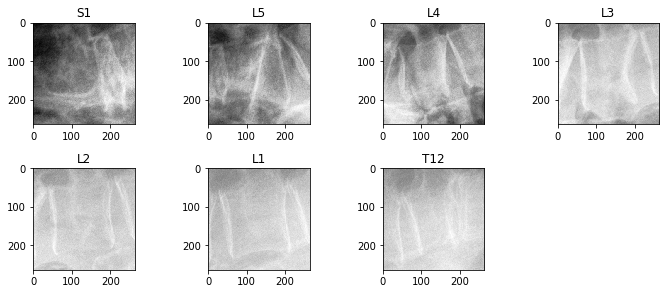

In [36]:
'''
data augmentation change grey
'''


"""
rotate image 
"""

rst_img = {}
# print(pieceDict[''])
for i,vb in enumerate(pieceDict):
    # rotate the image pieces
    npa = pieceDict[vb]
#     print(pieceDict_[vb].shape)
    rotated_img, rotated_box = image_rotate(npa, pieceBoxDict[vb], is_right)
    # make sure the rotated_box is horizontal
    xy_range = go.get_straight_box(rotated_box)
    rst_img[vb] = get_one_piece(rotated_img, xy_range)

"""
resize the image
"""
resized_img = {}
for i,vb in enumerate(pieceDict):
    y_len, x_len = rst_img[vb].shape
    x_scale = resized_img_size[0]/x_len
    y_scale = resized_img_size[1]/y_len
    resized_img[vb] = image_resize(rst_img[vb], x_scale, y_scale)

###########################################################
# below is plot related
###########################################################
fig5 = plt.figure(figsize=(10,8))
axes5 = []
for i,vb in enumerate(pieceDict):    
    axes5.append(plt.subplot(4,4,i+1))
#     axes5[i].set_axis_off()
    axes5[i].set_title(vb)
    min_intensity = resized_img[vb].min()
    max_intensity = resized_img[vb].max()
    axes5[i].imshow(resized_img[vb],
                cmap=plt.cm.Greys_r,
                vmin=min_intensity,
                vmax=max_intensity)
fig5.tight_layout()

In [37]:
def _data_aug_rules():
    pass

def data_augmentation():
    pass